# Creación de indicadores a nivel de radio y fracción censal

In [310]:
import pyredatam
from pyredatam import cpv2010arg
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scripts.path_finders import get_indicators_path, get_division_path, get_transport_shp_path
from scripts.create_indicators import get_data, replace_index, get_or_create_indicators_df, get_data_from_query
from scripts.geo_utils import join_df_with_shp, get_shapely_shape, iter_shp_as_shapely
%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")

Cargamos todos los datos necesarios de la base REDATAM en data frames. El método `get_data` descarga los datos de la base del Censo 2010 (es necesario tener Firefox instalado), a menos que ya estén en la carpeta *data/censo*.

In [311]:
variables = ["PERSONA.CONDACT", "VIVIENDA.V02", "PERSONA.EDADAGRU",
             "VIVIENDA.INCALCONS", "VIVIENDA.INCALSERV", "HOGAR.ALGUNBI", "HOGAR.INDHAC",
             "HOGAR.H19A", "HOGAR.H19B", "HOGAR.H19C", "HOGAR.H19D", "HOGAR.H05", "HOGAR.H12"]

In [312]:
dfs_radio = [get_data("RADIO", variable, redownload=False) for variable in variables]
dfs_frac = [get_data("FRAC", variable, redownload=False) for variable in variables]
dfs_comuna = [get_data("DPTO", variable, redownload=False) for variable in variables]
dfs_caba = [get_data("PROV", variable, redownload=False) for variable in variables]

In [313]:
dfs_comuna[0].head()

,Ocupado,Desocupado,Inactivo,Total,COMUNAS
Código,,,,,
02001,115106,5478,40224,160808,1
02002,94799,3703,38033,136535,2
02003,111137,4974,40042,156153,3
02004,117188,6758,49626,173572,4
02005,107804,4481,39007,151292,5


## Chequeos de consistencia

La cantidad de radios, fracciones, comunas y Ciudades de Buenos Aires (1 sola), debe coincidir para todas las variables censales descargadas.

In [314]:
print "RADIO # de radios", [len(df_radio) for df_radio in dfs_radio]
print "FRAC # de fracciones", [len(df_frac) for df_frac in dfs_frac]
print "DPTO # de comunas", [len(df_comuna) for df_comuna in dfs_comuna]
print "PROV # de CABAs", [len(df_caba) for df_caba in dfs_caba]

RADIO # de radios [3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553]
FRAC # de fracciones [351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351]
DPTO # de comunas [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
PROV # de CABAs [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


La suma del total de cada variable censal debe coincidir en distintos niveles de agregación.

In [315]:
for df_frac, df_radio, df_comuna, df_caba, variable in zip(dfs_frac, dfs_radio, dfs_comuna, dfs_caba, variables):
    
    total_frac = sum(df_frac["Total"])
    total_radio = sum(df_radio["Total"])
    total_comuna = sum(df_comuna["Total"])
    total_caba = sum(df_caba["Total"])
    
    print variable.ljust(18), total_radio, total_frac, total_comuna, total_caba, 
    print total_radio == total_frac == total_comuna == total_caba

PERSONA.CONDACT    2390725.0 2390725.0 2390725.0 2390725.0 True
VIVIENDA.V02       1423973.0 1423973.0 1423973.0 1423973.0 True
PERSONA.EDADAGRU   2890151.0 2890151.0 2890151.0 2890151.0 True
VIVIENDA.INCALCONS 1082998.0 1082998.0 1082998.0 1082998.0 True
VIVIENDA.INCALSERV 1082998.0 1082998.0 1082998.0 1082998.0 True
HOGAR.ALGUNBI      1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.INDHAC       1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19A         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19B         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19C         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19D         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H05          1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H12          1140209.0 1140209.0 1140209.0 1140209.0 True


## Creación de indicadores censales

In [316]:
indicators_radio = get_or_create_indicators_df("RADIO", dfs_radio[0])
indicators_frac = get_or_create_indicators_df("FRAC", dfs_frac[0])
indicators_comuna = get_or_create_indicators_df("DPTO", dfs_comuna[0])
indicators_caba = get_or_create_indicators_df("PROV", dfs_caba[0])

In [317]:
indicators_radio.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,...,COMERCIAL,INDUSTRIAL,SERVICIOS,OTROS,CO_FRAC_RA,educ_priv,educ_pub,hospitales,esp_verde,nse_alt
Código,,,,,,,,,,,,,,,,,,,,,
020010101,0.652778,0.035897,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,...,0.600394,0,0.273966,0.12564,1_1_1,4,3,0,0.084804,5
020010201,0.680851,0.050847,0.300912,0.905405,0.311715,0.661088,0.027197,478,0.074627,0.492537,...,0.000000,0,1.000000,0.00000,1_2_1,0,0,0,0.117467,6
020010202,0.615094,0.084270,0.347170,0.950000,0.339152,0.648379,0.012469,401,0.087719,0.482456,...,NaN,NaN,NaN,NaN,1_2_2,0,0,0,0.000000,6
020010203,0.639485,0.102410,0.334764,0.942308,0.308605,0.673591,0.017804,337,0.081633,0.438776,...,NaN,NaN,NaN,NaN,1_2_3,0,0,0,0.000000,6
020010204,0.727500,0.058252,0.280000,0.924370,0.335548,0.649502,0.014950,602,0.118182,0.600000,...,0.000000,0,1.000000,0.00000,1_2_4,0,1,0,0.000000,6


In [318]:
indicators_frac.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,serv_satisf,serv_basica,serv_insuf,nbi,hac-149,hac+150,terr_14,CO_FRACC
Código,,,,,,,,,,,,,,,,,,,
0200101,0.652778,0.035897,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,0.263158,0.894737,0.026316,0.078947,0.292308,0.661538,0.338462,NaN,001_1
0200102,0.694599,0.072142,0.272439,0.953185,0.298408,0.686116,0.015476,11243,0.118538,0.477843,0.403619,0.884417,0.027326,0.088257,0.290628,0.436078,0.563922,NaN,001_2
0200103,0.728815,0.066722,0.239014,0.929540,0.321379,0.669561,0.009060,15894,0.066384,0.305085,0.628531,0.776836,0.050847,0.172316,0.348619,0.346892,0.653108,NaN,001_3
0200104,0.667888,0.033735,0.293582,0.588288,0.131198,0.650685,0.218117,10366,0.935988,0.054824,0.009188,0.993874,0.001531,0.004594,0.024396,0.903126,0.096874,NaN,001_4
0200105,0.632911,0.040000,0.286498,0.592682,0.124492,0.657739,0.217769,5414,0.926010,0.067181,0.006809,0.998184,0.000454,0.001362,0.006170,0.919788,0.080212,NaN,001_5


In [319]:
def calculate_indicators_CONDACT(df_indicators, df_condact, df_edadgru):
    pobl_14_mas = df_edadgru["Total"] - df_edadgru["0 - 14"]
    pea = df_condact["Ocupado"] + df_condact["Desocupado"]
    df_indicators["empleo"] = df_condact["Ocupado"] / pobl_14_mas
    df_indicators["desocup"] = df_condact["Desocupado"] / pea
    df_indicators["inact"] = df_condact["Inactivo"] / pobl_14_mas

def calculate_indicators_V02(df_indicators, df):
    df_indicators["ocup_viv"] = df["Con personas presentes"] / df["Total"]

def calculate_indicators_EDADGRU(df_indicators, df):
    df_indicators["0_14"] = df["0 - 14"] / df["Total"]
    df_indicators["15_64"] = df["15 - 64"] / df["Total"]
    df_indicators["mas_65"] = df["65 y más".decode("utf-8")] / df["Total"]
    df_indicators["hab"] = df["Total"]

def calculate_indicators_INCALCONS(df_indicators, df):
    df_indicators["con_satisf"] = df["Satisfactoria"] / df["Total"]
    df_indicators["con_basica"] = df["Básica".decode("utf-8")] / df["Total"]
    df_indicators["con_insuf"] = df["Insuficiente"] / df["Total"]

def calculate_indicators_INCALSERV(df_indicators, df):
    df_indicators["serv_satisf"] = df["Satisfactoria"] / df["Total"]
    df_indicators["serv_basica"] = df["Básica".decode("utf-8")] / df["Total"]
    df_indicators["serv_insuf"] = df["Insuficiente"] / df["Total"]

def calculate_indicators_ALGUNBI(df_indicators, df):
    df_indicators["nbi"] = df["Hogares con NBI"] / df["Total"]

def calculate_indicators_INDHAC(df_indicators, df):
    df_indicators["hac-149"] = sum((df["Hasta   0.50 personas por cuarto"],
                                                df["0.51  -  0.99  personas por cuarto"],
                                                df["1.00  -  1.49  personas por cuarto"])) / df["Total"]
    
    df_indicators["hac+150"] = sum((df["1.50  -  1.99  personas por cuarto"],
                                                df["2.00  -  3.00  personas por cuarto"],
                                                df["Más de  3.00 personas por cuarto".decode("utf-8")])) / df["Total"]

In [320]:
def calculate_indicators(dfs, df_indicators):
    calculate_indicators_CONDACT(df_indicators, dfs[0], dfs[2])
    calculate_indicators_V02(df_indicators, dfs[1])
    calculate_indicators_EDADGRU(df_indicators, dfs[2])
    calculate_indicators_INCALCONS(df_indicators, dfs[3])
    calculate_indicators_INCALSERV(df_indicators, dfs[4])
    calculate_indicators_ALGUNBI(df_indicators, dfs[5])
    calculate_indicators_INDHAC(df_indicators, dfs[6])

calculate_indicators(dfs_radio, indicators_radio)
calculate_indicators(dfs_frac, indicators_frac)
calculate_indicators(dfs_comuna, indicators_comuna)
calculate_indicators(dfs_caba, indicators_caba)

In [321]:
indicators_frac.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,serv_satisf,serv_basica,serv_insuf,nbi,hac-149,hac+150,terr_14,CO_FRACC
Código,,,,,,,,,,,,,,,,,,,
0200101,0.652778,0.035897,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,0.263158,0.894737,0.026316,0.078947,0.292308,0.661538,0.338462,NaN,001_1
0200102,0.694599,0.072142,0.272439,0.953185,0.298408,0.686116,0.015476,11243,0.118538,0.477843,0.403619,0.884417,0.027326,0.088257,0.290628,0.436078,0.563922,NaN,001_2
0200103,0.728815,0.066722,0.239014,0.929540,0.321379,0.669561,0.009060,15894,0.066384,0.305085,0.628531,0.776836,0.050847,0.172316,0.348619,0.346892,0.653108,NaN,001_3
0200104,0.667888,0.033735,0.293582,0.588288,0.131198,0.650685,0.218117,10366,0.935988,0.054824,0.009188,0.993874,0.001531,0.004594,0.024396,0.903126,0.096874,NaN,001_4
0200105,0.632911,0.040000,0.286498,0.592682,0.124492,0.657739,0.217769,5414,0.926010,0.067181,0.006809,0.998184,0.000454,0.001362,0.006170,0.919788,0.080212,NaN,001_5


In [322]:
indicators_radio.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,...,COMERCIAL,INDUSTRIAL,SERVICIOS,OTROS,CO_FRAC_RA,educ_priv,educ_pub,hospitales,esp_verde,nse_alt
Código,,,,,,,,,,,,,,,,,,,,,
020010101,0.652778,0.035897,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,...,0.600394,0,0.273966,0.12564,1_1_1,4,3,0,0.084804,5
020010201,0.680851,0.050847,0.300912,0.905405,0.311715,0.661088,0.027197,478,0.074627,0.492537,...,0.000000,0,1.000000,0.00000,1_2_1,0,0,0,0.117467,6
020010202,0.615094,0.084270,0.347170,0.950000,0.339152,0.648379,0.012469,401,0.087719,0.482456,...,NaN,NaN,NaN,NaN,1_2_2,0,0,0,0.000000,6
020010203,0.639485,0.102410,0.334764,0.942308,0.308605,0.673591,0.017804,337,0.081633,0.438776,...,NaN,NaN,NaN,NaN,1_2_3,0,0,0,0.000000,6
020010204,0.727500,0.058252,0.280000,0.924370,0.335548,0.649502,0.014950,602,0.118182,0.600000,...,0.000000,0,1.000000,0.00000,1_2_4,0,1,0,0.000000,6


In [323]:
indicators_comuna.head()

,COMUNAS,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,serv_satisf,serv_basica,serv_insuf,nbi,hac-149,hac+150
Código,,,,,,,,,,,,,,,,,,
02001,1,0.660940,0.045429,0.230967,0.599215,0.154119,0.704424,0.141457,205886,0.754696,0.135260,0.110043,0.949451,0.007300,0.043249,0.158983,0.762265,0.237735
02002,2,0.674582,0.037593,0.270640,0.656395,0.110187,0.691848,0.197965,157932,0.918893,0.070327,0.010780,0.991731,0.001467,0.006801,0.020463,0.913787,0.086213
02003,3,0.697068,0.042838,0.251149,0.747373,0.149848,0.690034,0.160118,187537,0.856028,0.100007,0.043965,0.981377,0.002910,0.015713,0.118774,0.795227,0.204773
02004,4,0.679359,0.054524,0.287690,0.840267,0.209613,0.661541,0.128846,218245,0.728660,0.183396,0.087945,0.948177,0.016518,0.035304,0.126584,0.727461,0.272539
02005,5,0.704394,0.039907,0.254873,0.789499,0.145024,0.682914,0.172062,179005,0.883648,0.092044,0.024308,0.986822,0.002813,0.010365,0.060537,0.855477,0.144523


In [324]:
indicators_caba.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,serv_satisf,serv_basica,serv_insuf,nbi,hac-149,hac+150
Código,,,,,,,,,,,,,,,,,
02,0.68422,0.042921,0.273963,0.760547,0.16349,0.67248,0.16403,2890151,0.856398,0.109963,0.033639,0.980572,0.005062,0.014366,0.059798,0.844103,0.155897


## Creación de otros indicadores

### 2. Indicador de nivel socioeconómico

#### 2.a) Versión DOT México

*Índice de escolaridad*

In [328]:
df_asist_educ = get_data("RADIO", "PERSONA.P08", "PERSONA.EDAD < 18")

In [329]:
def calculate_escolaridad_indicator(df_indicators, df_asist_educ):
    df_indicators["escolaridad"] = df_asist_educ["Asiste"] / df_asist_educ["Total"]

In [330]:
calculate_escolaridad_indicator(indicators_radio, df_asist_educ)

In [331]:
indicators_radio["escolaridad"].head()

Código
020010101    0.843137
020010201    0.867647
020010202    0.862595
020010203    0.843137
020010204    0.903382
Name: escolaridad, dtype: float64

*Índice de educación superior*

In [332]:
df_educ_sup = get_data("RADIO", "PERSONA.P09", "PERSONA.EDAD > 25 AND PERSONA.P10 = 1")

In [333]:
def calculate_educ_sup_indicator(df_indicators, df_educ_sup):
    df_indicators["educ_sup"] = (df_educ_sup["Universitario"] + df_educ_sup["Post universitario"]) / df_educ_sup["Total"]

In [334]:
calculate_educ_sup_indicator(indicators_radio, df_educ_sup)

In [335]:
indicators_radio["educ_sup"].head()

Código
020010101    0.102362
020010201    0.056911
020010202    0.022222
020010203    0.039474
020010204    0.008929
Name: educ_sup, dtype: float64

*Índice de computadora*

In [336]:
df_compu = get_data("RADIO", "HOGAR.H19B", "HOGAR.H19A = 1 OR HOGAR.H19B = 1 OR HOGAR.H19C = 1 OR HOGAR.H19D = 1")

In [337]:
def calculate_compu_indicator(df_indicators, df_compu):
    df_indicators["compu"] = df_compu["Sí".decode("utf-8")] / df_compu["Total"]

In [338]:
calculate_compu_indicator(indicators_radio, df_compu)

In [339]:
indicators_radio["compu"].head()

Código
020010101    0.500000
020010201    0.280000
020010202    0.192000
020010203    0.438776
020010204    0.432258
Name: compu, dtype: float64

**Índice de Nivel Socio-Económico**

In [340]:
df_nse_mexico = indicators_radio[["educ_sup", "escolaridad", "compu"]]

In [341]:
df_nse_mexico.head()

,educ_sup,escolaridad,compu
Código,,,
020010101,0.102362,0.843137,0.500000
020010201,0.056911,0.867647,0.280000
020010202,0.022222,0.862595,0.192000
020010203,0.039474,0.843137,0.438776
020010204,0.008929,0.903382,0.432258


In [342]:
# correlación entre los tres índices
df_nse_mexico.corr()

,educ_sup,escolaridad,compu
educ_sup,1.000000,0.496032,0.792191
escolaridad,0.496032,1.000000,0.648060
compu,0.792191,0.648060,1.000000


In [343]:
df_nse_mexico_clean = df_nse_mexico.dropna()

In [344]:
pca = PCA(n_components=3)
pca.fit(df_nse_mexico_clean)

PCA(copy=True, n_components=3, whiten=False)

In [345]:
pca.explained_variance_ratio_

array([ 0.88315721,  0.10113534,  0.01570745])

In [346]:
params_pc1 = pca.components_[0]
pca.components_

array([[ 0.76120783,  0.10759338,  0.63952037],
       [ 0.64799446, -0.16542885, -0.74346249],
       [-0.02580348, -0.98033513,  0.19564565]])

In [347]:
df_nse_mexico_clean["nse_mex"] = df_nse_mexico_clean.dot(params_pc1)
df_nse_mexico_clean["nse_mex_av"] = (df_nse_mexico_clean["educ_sup"] + 
                                     df_nse_mexico_clean["escolaridad"] + 
                                     df_nse_mexico_clean["compu"]) / 3

/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [348]:
df_nse_mexico_clean.corr()

,educ_sup,escolaridad,compu,nse_mex,nse_mex_av
educ_sup,1.000000,0.496032,0.792132,0.960914,0.941003
escolaridad,0.496032,1.000000,0.648060,0.603323,0.671367
compu,0.792132,0.648060,1.000000,0.929909,0.944568
nse_mex,0.960914,0.603323,0.929909,1.000000,0.995746
nse_mex_av,0.941003,0.671367,0.944568,0.995746,1.000000


In [349]:
serie = df_nse_mexico_clean["nse_mex"]

In [350]:
step = (serie.max() - serie.min()) / 7
serie.min(), serie.mean(), serie.max(), step

(0.14404460380765413,
 0.77192848760959687,
 1.3242231523148409,
 0.16859693550102667)

In [351]:
bins = np.arange(serie.min(), serie.max()*1.01, step)
print "Hay", len(bins) - 1, "categorías:", bins
nse_mex_categories = pd.cut(serie, bins, labels=range(1, 8))
nse_mex_categories.tail()

Hay 7 categorías: [ 0.1440446   0.31264154  0.48123847  0.64983541  0.81843235  0.98702928
  1.15562622  1.32422315]


Código
020152109    4
020152110    5
020152111    6
020152112    4
020152113    4
Name: nse_mex, dtype: category
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [352]:
indicators_radio["nse_mex_cat"] = nse_mex_categories

In [353]:
indicators_radio.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,...,COMERCIAL,INDUSTRIAL,SERVICIOS,OTROS,CO_FRAC_RA,educ_priv,educ_pub,hospitales,esp_verde,nse_alt
Código,,,,,,,,,,,,,,,,,,,,,
020010101,0.652778,0.035897,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,...,0.600394,0,0.273966,0.12564,1_1_1,4,3,0,0.084804,5
020010201,0.680851,0.050847,0.300912,0.905405,0.311715,0.661088,0.027197,478,0.074627,0.492537,...,0.000000,0,1.000000,0.00000,1_2_1,0,0,0,0.117467,6
020010202,0.615094,0.084270,0.347170,0.950000,0.339152,0.648379,0.012469,401,0.087719,0.482456,...,NaN,NaN,NaN,NaN,1_2_2,0,0,0,0.000000,6
020010203,0.639485,0.102410,0.334764,0.942308,0.308605,0.673591,0.017804,337,0.081633,0.438776,...,NaN,NaN,NaN,NaN,1_2_3,0,0,0,0.000000,6
020010204,0.727500,0.058252,0.280000,0.924370,0.335548,0.649502,0.014950,602,0.118182,0.600000,...,0.000000,0,1.000000,0.00000,1_2_4,0,1,0,0.000000,6


#### 2.b) Versión alternativa

In [354]:
nse_alt = pd.DataFrame(index=indicators_radio.index)

*Criterio 1*

*Criterio 2*

% de jefes de hogar con estudios universitarios o post-universitarios

In [355]:
query_educ_jefes = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT HOGAR
    TYPE INTEGER

DEFINE HOGAR.EDUCJEFE 
    AS PERSONA.P09
    FOR PERSONA.P01 = 1 
    RANGE 1-9
    TYPE INTEGER
    VARLABEL "Nivel educativo del jefe del hogar"

DEFINE HOGAR.JEFETER
    AS PERSONA.P10
    FOR PERSONA.P01 = 1 
    RANGE 1-2
    TYPE INTEGER
    VARLABEL "Jefe de hogar terminó el nivel educativo" 
    
DEFINE HOGAR.JEFEUNIV
    AS ((HOGAR.EDUCJEFE = 7 AND HOGAR.JEFETER = 1) OR HOGAR.EDUCJEFE = 8)
    TYPE INTEGER
    RANGE 0-1

TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, HOGAR.JEFEUNIV
"""

In [356]:
df_educ_jefes = get_data_from_query("RADIO", query_educ_jefes, redownload=False)
df_educ_jefes.head()

,COUNTER,0,1,Total,CO_FRAC_RA
Código,,,,,
020010101,93,81,7,88,1_1_1
020010201,162,154,4,158,1_2_1
020010202,132,126,2,128,1_2_2
020010203,104,100,1,101,1_2_3
020010204,164,158,0,158,1_2_4


In [357]:
hogares_contestaron = df_educ_jefes["Total"].sum()
hogares_totales = df_educ_jefes["COUNTER"].sum()
print hogares_contestaron, hogares_totales, hogares_contestaron / hogares_totales

1141371.0 1152599.0 0.990258537445


In [358]:
df_educ_jefes["ratio"] = df_educ_jefes["1"] / df_educ_jefes["Total"]
df_educ_jefes.head()

,COUNTER,0,1,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,93,81,7,88,1_1_1,0.079545
020010201,162,154,4,158,1_2_1,0.025316
020010202,132,126,2,128,1_2_2,0.015625
020010203,104,100,1,101,1_2_3,0.009901
020010204,164,158,0,158,1_2_4,0.000000


In [359]:
df_educ_jefes["1"].sum() / df_educ_jefes["Total"].sum()

0.23612392464851481

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f703cd0>]], dtype=object)

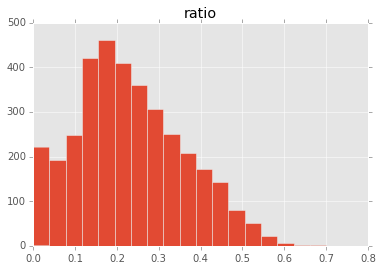

In [360]:
df_educ_jefes.hist("ratio", bins=18)

% de hogares con servicio doméstico con cama

In [361]:
query_serv_dom = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT HOGAR
    TYPE INTEGER

DEFINE HOGAR.SDOMCANT
    AS COUNT PERSONA
    FOR (PERSONA.P01 = 9)
    TYPE INTEGER

DEFINE HOGAR.SERVDOM
    AS HOGAR.SDOMCANT > 0
    TYPE INTEGER
    RANGE 0-1
    
TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, HOGAR.SERVDOM
"""

In [362]:
df_serv_dom = get_data_from_query("RADIO", query_serv_dom, redownload=False)
df_serv_dom.head()

,COUNTER,0,1,Total,CO_FRAC_RA
Código,,,,,
020010101,93,93,0,93,1_1_1
020010201,162,162,0,162,1_2_1
020010202,132,132,0,132,1_2_2
020010203,104,104,0,104,1_2_3
020010204,164,164,0,164,1_2_4


In [363]:
hogares_contestaron = df_serv_dom["Total"].sum()
hogares_totales = df_serv_dom["COUNTER"].sum()
print hogares_contestaron, hogares_totales, hogares_contestaron / hogares_totales

1152599.0 1152599.0 1.0


In [364]:
df_serv_dom["ratio"] = df_serv_dom["1"] / df_serv_dom["Total"]
df_serv_dom.head()

,COUNTER,0,1,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,93,93,0,93,1_1_1,0
020010201,162,162,0,162,1_2_1,0
020010202,132,132,0,132,1_2_2,0
020010203,104,104,0,104,1_2_3,0
020010204,164,164,0,164,1_2_4,0


In [365]:
df_serv_dom["1"].sum() / df_serv_dom["Total"].sum()

0.0086370021143519996

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1158f80d0>]], dtype=object)

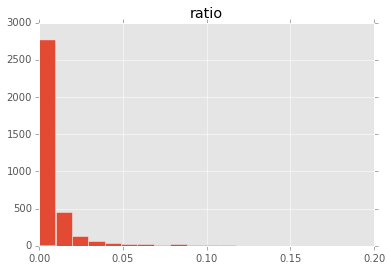

In [366]:
df_serv_dom.hist("ratio", bins=20)

% de personas de 14 a 25 años sin secundario, que asiste al secundario

In [367]:
query_asist_sec = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT PERSONA
    TYPE INTEGER

DEFINE PERSONA.ASISTSEC
    AS PERSONA.P08
    FOR ((PERSONA.P09 = 1 OR PERSONA.P09 = 2 OR PERSONA.P09 = 3
         OR (PERSONA.P09 = 4 AND PERSONA.P08 = 1)) AND PERSONA.EDAD >= 14 AND
         PERSONA.EDAD <= 25)
    TYPE INTEGER
    RANGE 1-3
    
TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, PERSONA.ASISTSEC
"""

In [368]:
df_asist_sec = get_data_from_query("RADIO", query_asist_sec, redownload=False)
df_asist_sec.head()

,COUNTER,1,2,Total,CO_FRAC_RA
Código,,,,,
020010101,336,20,8,28,1_1_1
020010201,478,51,21,72,1_2_1
020010202,401,34,21,55,1_2_2
020010203,337,38,11,49,1_2_3
020010204,602,79,19,98,1_2_4


In [369]:
universo_relevante = df_asist_sec["Total"].sum()
personas_totales = df_asist_sec["COUNTER"].sum()
print universo_relevante, personas_totales, universo_relevante / personas_totales

172687.0 2890151.0 0.0597501653028


In [370]:
df_asist_sec["ratio"] = df_asist_sec["1"] / df_asist_sec["Total"]
df_asist_sec.head()

,COUNTER,1,2,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,336,20,8,28,1_1_1,0.714286
020010201,478,51,21,72,1_2_1,0.708333
020010202,401,34,21,55,1_2_2,0.618182
020010203,337,38,11,49,1_2_3,0.775510
020010204,602,79,19,98,1_2_4,0.806122


In [371]:
df_asist_sec["1"].sum() / df_asist_sec["Total"].sum()

0.87295511532425718

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114e4abd0>]], dtype=object)

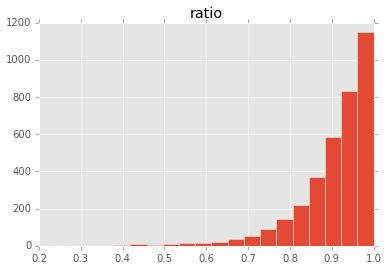

In [372]:
df_asist_sec.hist("ratio", bins=20)

*Criterio 3*

% de hogares con "piso precario"

In [373]:
df_piso = dfs_radio[11]
df_piso["ratio"] = (df_piso["Tierra o ladrillo suelto"] + df_piso["Otro"]) / df_piso["Total"]
df_piso.head()

,"Cerámica, baldosa, mosaico, mármol, madera o alfombrado",Cemento o ladrillo fijo,Tierra o ladrillo suelto,Otro,Total,CO_FRAC_RA,ratio
Código,,,,,,,
020010101,43,20,0,2,65,1_1_1,0.030769
020010201,47,95,14,5,161,1_2_1,0.118012
020010202,46,80,2,0,128,1_2_2,0.015625
020010203,29,73,1,1,104,1_2_3,0.019231
020010204,69,91,2,1,163,1_2_4,0.018405


In [374]:
(df_piso["Tierra o ladrillo suelto"].sum() + df_piso["Otro"].sum()) / df_piso["Total"].sum()

0.0071113452867231121

In [375]:
df_piso["ratio"].max(), df_piso["ratio"].mean(), df_piso["ratio"].min()

(0.77777777777777779, 0.0070729021688079267, 0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112d13850>]], dtype=object)

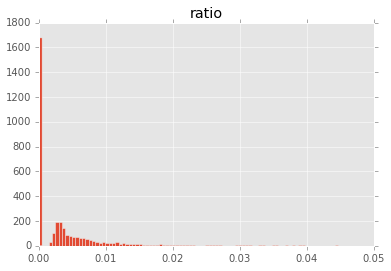

In [376]:
df_piso[df_piso["ratio"] < 0.05].hist("ratio", bins=100)

% de personas entre 18 y 29 años que usa computadora

In [377]:
query_joven_compu = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT PERSONA
    TYPE INTEGER

DEFINE PERSONA.USACOMPU
    AS PERSONA.P12
    FOR (PERSONA.EDAD >= 18 AND PERSONA.EDAD <= 29)
    TYPE INTEGER
    RANGE 1-2
    
TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, PERSONA.USACOMPU
"""

In [378]:
df_joven_compu = get_data_from_query("RADIO", query_joven_compu, redownload=False)
df_joven_compu.head()

,COUNTER,1,2,Total,CO_FRAC_RA
Código,,,,,
020010101,336,46,14,60,1_1_1
020010201,478,91,45,136,1_2_1
020010202,401,58,47,105,1_2_2
020010203,337,64,25,89,1_2_3
020010204,602,124,35,159,1_2_4


In [379]:
universo_relevante = df_joven_compu["Total"].sum()
personas_totales = df_joven_compu["COUNTER"].sum()
print universo_relevante, personas_totales, universo_relevante / personas_totales

540727.0 2890151.0 0.187092992719


In [380]:
df_joven_compu["ratio"] = df_joven_compu["1"] / df_joven_compu["Total"]
df_joven_compu.head()

,COUNTER,1,2,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,336,46,14,60,1_1_1,0.766667
020010201,478,91,45,136,1_2_1,0.669118
020010202,401,58,47,105,1_2_2,0.552381
020010203,337,64,25,89,1_2_3,0.719101
020010204,602,124,35,159,1_2_4,0.779874


In [381]:
df_joven_compu["1"].sum() / df_joven_compu["Total"].sum()

0.89974608258881095

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1131a7810>]], dtype=object)

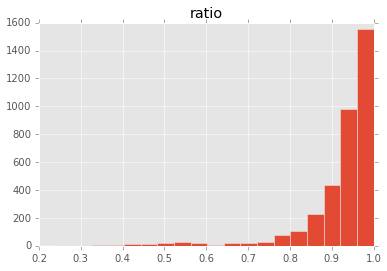

In [382]:
df_joven_compu.hist("ratio", bins=20)

*Criterio 4*

% de personas con desagüe a hoyo o pozo

In [383]:
df_desague = dfs_radio[12]

In [384]:
df_desague["ratio"] = (df_desague["Sólo a pozo ciego".decode("utf-8")] + 
                       df_desague["A hoyo, excavación en la tierra, etc.".decode("utf-8")]) / df_desague["Total"]
df_desague.head()

,A red pública (cloaca),A cámara séptica y pozo ciego,Sólo a pozo ciego,"A hoyo, excavación en la tierra, etc.",Total,CO_FRAC_RA,ratio
Código,,,,,,,
020010101,60,3,1,1,65,1_1_1,0.030769
020010201,124,2,8,0,134,1_2_1,0.059701
020010202,111,9,6,0,126,1_2_2,0.047619
020010203,87,9,3,0,99,1_2_3,0.030303
020010204,155,5,2,0,162,1_2_4,0.012346


In [385]:
(df_desague["Sólo a pozo ciego".decode("utf-8")].sum() + 
 df_desague["A hoyo, excavación en la tierra, etc.".decode("utf-8")].sum()) / df_desague["Total"].sum()

0.0040159304127576614

In [386]:
df_desague["ratio"].max(), df_desague["ratio"].mean(), df_desague["ratio"].min()

(0.75839999999999996, 0.0036487894407812569, 0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114c05650>]], dtype=object)

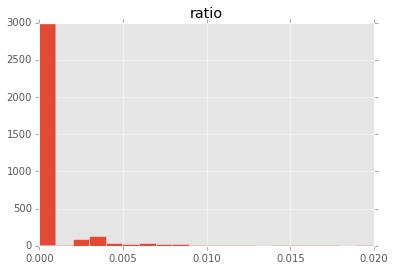

In [387]:
df_desague[df_desague["ratio"] < 0.02].hist("ratio", bins=20)

% de hogares con jefes con educación secundaria completa

In [388]:
query_jefe_secun = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT HOGAR
    TYPE INTEGER

DEFINE HOGAR.EDUCJEFE 
    AS PERSONA.P09
    FOR PERSONA.P01 = 1 
    RANGE 1-9
    TYPE INTEGER
    VARLABEL "Nivel educativo del jefe del hogar" 

DEFINE HOGAR.JEFETER
    AS PERSONA.P10
    FOR PERSONA.P01 = 1 
    RANGE 1-2
    TYPE INTEGER
    VARLABEL "Jefe de hogar terminó el nivel educativo" 

DEFINE HOGAR.JEFEUNIV
    AS (HOGAR.EDUCJEFE = 8 OR HOGAR.EDUCJEFE = 7 OR HOGAR.EDUCJEFE = 6 OR
        ((HOGAR.EDUCJEFE = 5 OR HOGAR.EDUCJEFE = 4) AND HOGAR.JEFETER = 1))
    TYPE INTEGER
    RANGE 0-1

TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, HOGAR.JEFEUNIV
"""

In [389]:
df_jefe_secun = get_data_from_query("RADIO", query_jefe_secun, redownload=False)
df_jefe_secun.head()

,COUNTER,0,1,Total,CO_FRAC_RA
Código,,,,,
020010101,93,41,47,88,1_1_1
020010201,162,108,50,158,1_2_1
020010202,132,90,38,128,1_2_2
020010203,104,66,35,101,1_2_3
020010204,164,112,46,158,1_2_4


In [390]:
universo_relevante = df_jefe_secun["Total"].sum()
hogares_totales = df_jefe_secun["COUNTER"].sum()
print universo_relevante, hogares_totales, universo_relevante / hogares_totales

1141371.0 1152599.0 0.990258537445


In [391]:
df_jefe_secun["ratio"] = df_jefe_secun["1"] / df_jefe_secun["Total"]
df_jefe_secun.head()

,COUNTER,0,1,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,93,41,47,88,1_1_1,0.534091
020010201,162,108,50,158,1_2_1,0.316456
020010202,132,90,38,128,1_2_2,0.296875
020010203,104,66,35,101,1_2_3,0.346535
020010204,164,112,46,158,1_2_4,0.291139


In [392]:
print df_jefe_secun["1"].sum() / df_jefe_secun["Total"].sum()

0.716206211652


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113765790>]], dtype=object)

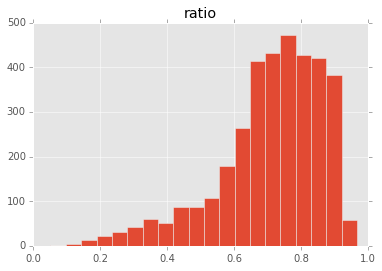

In [393]:
df_jefe_secun.hist("ratio", bins=20)

In [394]:
from scripts.nse import NSE

indicators = {
    "con_satisf": (0.6, indicators_radio["con_satisf"]),
    "pers_domestico": (0.03, df_serv_dom["ratio"]),
    "asist_secundario": (0.6, df_asist_sec["ratio"]),
    "jefes_univ": (0.4, df_educ_jefes["ratio"]),
    "piso_c3": (0.01, df_piso["ratio"]),
    "piso_c4": (0.99, df_piso["ratio"]),
    "joven_compu": (0.85, df_joven_compu["ratio"]),
    "desague": (0.1, df_desague["ratio"]),
    "jefe_secun": (0.85, df_jefe_secun["ratio"])
}

nse = NSE(indicators)
nse.calc(nse_alt)

In [395]:
nse_alt["hab"] = indicators_radio["hab"]
total = pd.pivot_table(nse_alt, values='hab', columns=["nse_alt"], aggfunc=np.sum).sum()
parcial = pd.pivot_table(nse_alt, values='hab', columns=["nse_alt"], aggfunc=np.sum)
serie_per = parcial / total
serie_per
#serie_per.plot()

nse_alt
1    0.048813
2    0.112873
3    0.592083
4    0.108028
5    0.081543
6    0.042207
7    0.014453
Name: hab, dtype: float64

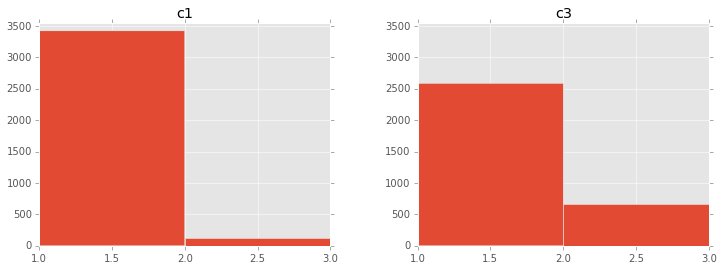

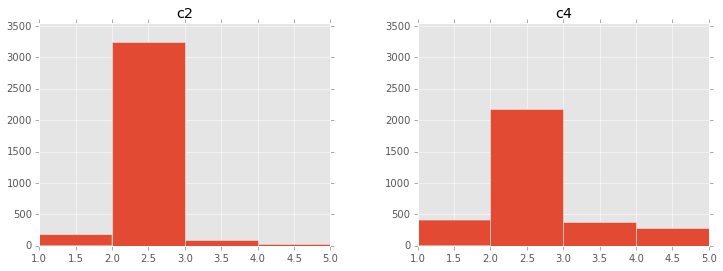

In [396]:
hists = np.append(nse_alt.hist(["c1", "c3"], bins=2, range=(1, 3), figsize=(12, 4))[0],
                  nse_alt.hist(["c2", "c4"], bins=4, range=(1, 5), figsize=(12, 4))[0])
hists = [hist.set_ylim((0, len(nse_alt))) for hist in hists]

(0, 3553)

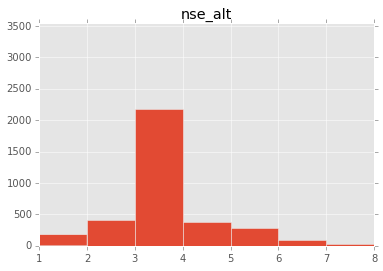

In [397]:
nse_alt.hist("nse_alt", bins=7, range=(1, 8))[0][0].set_ylim((0, len(nse_alt)))

In [398]:
indicators_radio["nse_alt"] = nse_alt["nse_alt"]

## Guardar indicadores en csv

In [399]:
indicators_radio.to_csv(get_indicators_path("RADIO"), encoding="utf-8")
indicators_frac.to_csv(get_indicators_path("FRAC"), encoding="utf-8")
indicators_comuna.to_csv(get_indicators_path("DPTO"), encoding="utf-8")
indicators_caba.to_csv(get_indicators_path("PROV"), encoding="utf-8")

## Añadir indicadores a sus shapefiles

In [400]:
join_df_with_shp(get_division_path("radios_censo_2010"), indicators_radio.set_index("CO_FRAC_RA"), "indicadores")
join_df_with_shp(get_division_path("fracciones_caba_censo_2010"), indicators_frac.set_index("CO_FRACC"), "indicadores")
join_df_with_shp(get_division_path("comunas_caba_censo_2010"), indicators_comuna.set_index("COMUNAS"), "indicadores")